## Interactive Variogram Calculation Demonstration


### The Interactive Workflow

Here's an interactive workflow for calculating directional experimental variograms in 2D. 

* setting the variogram calculation parameters for identifying spatial data pairs 

This approach is essential for quantifying spatial continuity with sparsely sampled, irregular spatial data.

I have more comprehensive workflows for variogram calculation:

* [Experimental Variogram Calculation in Python with GeostatsPy](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_variogram_calculation.ipynb)

* [Determination of Major and Minor Spatial Continuity Directions in Python with GeostatsPy](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/GeostatsPy_spatial_continuity_directions.ipynb)

#### Spatial Continuity 

**Spatial Continuity** is the correlation between values over distance.

* No spatial continuity – no correlation between values over distance, random values at each location in space regardless of separation distance.

* Homogenous phenomenon have perfect spatial continuity, since all values as the same (or very similar) they are correlated. 

We need a statistic to quantify spatial continuity! A convenient method is the Semivariogram.

#### The Semivariogram

Function of difference over distance.

* The expected (average) squared difference between values separated by a lag distance vector (distance and direction), $h$:

\begin{equation}
\gamma(\bf{h}) = \frac{1}{2 N(\bf{h})} \sum^{N(\bf{h})}_{\alpha=1} (z(\bf{u}_\alpha) - z(\bf{u}_\alpha + \bf{h}))^2  
\end{equation}

where $z(\bf{u}_\alpha)$ and $z(\bf{u}_\alpha + \bf{h})$ are the spatial sample values at tail and head locations of the lag vector respectively.

* Calculated over a suite of lag distances to obtain a continuous function.

* the $\frac{1}{2}$ term converts a variogram into a semivariogram, but in practice the term variogram is used instead of semivariogram.
* We prefer the semivariogram because it relates directly to the covariance function, $C_x(\bf{h})$ and univariate variance, $\sigma^2_x$:

\begin{equation}
C_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

Note the correlogram is related to the covariance function as:

\begin{equation}
\rho_x(\bf{h}) = \frac{C_x(\bf{h})}{\sigma^2_x}
\end{equation}

The correlogram provides of function of the $\bf{h}-\bf{h}$ scatter plot correlation vs. lag offset $\bf{h}$.  

\begin{equation}
-1.0 \le \rho_x(\bf{h}) \le 1.0
\end{equation}

#### Variogram Observations

The following are common observations for variograms that should assist with their practical use.

##### Observation \#1 - As distance increases, variability increase (in general).

This is common since in general, over greater distance offsets, there is often more difference between the head and tail samples.

In some cases, such as with spatial cyclicity of the hole effect variogram model the variogram may have negative slope over somelag distance intervals

Negative slopes at lag distances greater than half the data extent are often caused by too few pairs for a reliable variogram calculation

##### Observation \#2 - Calculated with over all possible pairs separated by lag vector, $\bf{𝐡}$.

We scan through the entire data set, searching for all possible pair combinations with all other data.  We then calculate the variogram as one half the expectation of squared difference between all pairs.

More pairs results in a more reliable measure.

##### Observation \#3 - Need to plot the sill to know the degree of correlation.

**Sill** is the variance, $\sigma^2_x$

Given stationarity of the variance, $\sigma^2_x$, and variogram $\gamma(\bf{h})$:

we can define the covariance function:

\begin{equation}
C_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

The covariance measure is a measure of similarity over distance (the mirror image of the variogram as shown by the equation above).

Given a standardized distribution $\sigma^2_x = 1.0$, the covariance, $C_x(\bf{h})$, is equal to the correlogram, $\rho_x(\bf{h})$: 

\begin{equation}
\rho_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

##### Observation \#4 - The lag distance at which the variogram reaches the sill is know as the range.

At the range, knowing the data value at the tail location provides no information about a value at the head location of the lag distance vector.

##### Observation \#5 - The nugget effect, a discontinuity at the origin

Sometimes there is a discontinuity in the variogram at distances less than the minimum data spacing.  This is known as **nugget effect**.

The ratio of nugget / sill, is known as relative nugget effect (%). Modeled as a discontinuity with no correlation structure that at lags, $h \gt \epsilon$, an infinitesimal lag distance, and perfect correlation at $\bf{h} = 0$.
Caution when including nuggect effect in the variogram model as measurement error, mixing populations cause apparent nugget effect

This exercise demonstrates the semivariogram calculation with GeostatsPy. The steps include:

1. generate a 2D model with sequential Gaussian simulation
2. sample from the simulation
3. calculate and visualize experimental semivariograms

#### Variogram Calculation Parameters

The variogram calculation parameters include:

* **azimuth** is the azimuth of the lag vector

* **azimuth tolerance** is the maximum allowable departure from the azimuth (isotropic variograms are calculated with an azimuth tolerance of to 90.0)

* **unit lag distance** the size of the bins in lag distance, usually set to the minimum data spacing

* **lag distance tolerance** - the allowable tolerance in lage distance, commonly set to 50% of unit lag distanceonal smoothing

* **number of lags** - set based on the spatial extent of the dataset, we can typically calculate reliable variograms up to 1/2 the extent of the dataset

* **bandwidth** is the maximum offset allowable from the lag vector 

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    


#### Load the required libraries

The following code loads the required libraries.

In [5]:
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python    

We will also need some standard packages. These should have been installed with Anaconda 3.

In [6]:
%matplotlib inline
import os                                               # to set current working directory 
import sys                                              # supress output to screen for interactive variogram modeling
import io
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from matplotlib.pyplot import cm                        # color maps
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from intake import cat

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  


#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

In [7]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load the data from Dr. Pyrcz's github repository
#print(df.iloc[0:5,:])                                  # display first 4 samples in the table as a preview
df.head()                                               # we could also use this command for a table preview 

,X,Y,Facies,Porosity,Perm
0,100,900,1,0.115359,5.736104
1,100,800,1,0.136425,17.211462
2,100,600,1,0.135810,43.724752
3,100,500,0,0.094414,1.609942
4,100,100,0,0.113049,10.886001


We will work with all facies pooled together. I wanted to simplify this workflow and focus more on spatial continuity direction detection. Finally, by not using facies we do have more samples to support our statistical inference. Most often facies are essential in the subsurface model. Don't worry we will check if this is reasonable in a bit.   

You are welcome to repeat this workflow on a by-facies basis.  The following code could be used to build DataFrames ('df_sand' and 'df_shale') for each facies.

```p
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records
```

Let's look at summary statistics for all facies combined:

In [8]:
df.describe().transpose()                               # summary table of sand only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
X,289.0,475.813149,254.277530,0.000000,300.000000,430.000000,670.000000,990.000000
Y,289.0,529.692042,300.895374,9.000000,269.000000,549.000000,819.000000,999.000000
Facies,289.0,0.813149,0.390468,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,289.0,0.134744,0.037745,0.058548,0.106318,0.126167,0.154220,0.228790
Perm,289.0,207.832368,559.359350,0.075819,3.634086,14.908970,71.454424,5308.842566


Let's transform the porosity and permeaiblity data to standard normal (mean = 0.0, standard deviation = 1.0, Gaussian shape). This is required for sequential Gaussian simulation (common target for our variogram models) and the Gaussian transform assists with outliers and provides more interpretable variograms. 

Let's look at the inputs for the GeostatsPy nscore program.  Note the output include an ndarray with the transformed values (in the same order as the input data in Dataframe 'df' and column 'vcol'), and the transformation table in original values and also in normal score values. 

In [9]:
geostats.nscore                                         # see the input parameters required by the nscore function

<function geostatspy.geostats.nscore(df, vcol, wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0)>

The following command will transform the Porosity and Permeabilty to standard normal. 

In [10]:
#Transform to Gaussian by Facies
df['NPor'], tvPor, tnsPor = geostats.nscore(df, 'Porosity') # nscore transform for all facies porosity 
df['NPerm'], tvPermSand, tnsPermSand = geostats.nscore(df, 'Perm')  # nscore transform for all facies permeability

Let's look at the updated DataFrame to make sure that we now have the normal score porosity and permeability.

In [11]:
df.head()                                               # preview sand DataFrame with nscore transforms

,X,Y,Facies,Porosity,Perm,NPor,NPerm
0,100,900,1,0.115359,5.736104,-0.391400,-0.429142
1,100,800,1,0.136425,17.211462,0.299307,0.112995
2,100,600,1,0.135810,43.724752,0.272201,0.556521
3,100,500,0,0.094414,1.609942,-1.269810,-1.178106
4,100,100,0,0.113049,10.886001,-0.496733,-0.156762


That looks good! One way to check is to see if the relative magnitudes of the normal score transformed values match the original values.  e.g. that the normal score transform of 0.10 porosity normal score is less than the normal score transform of 0.14 porsity.  Also, the normal score transform of values close to the mean value should be close to 0.0 

Let's also check the original and transformed sand and shale porosity distributions.

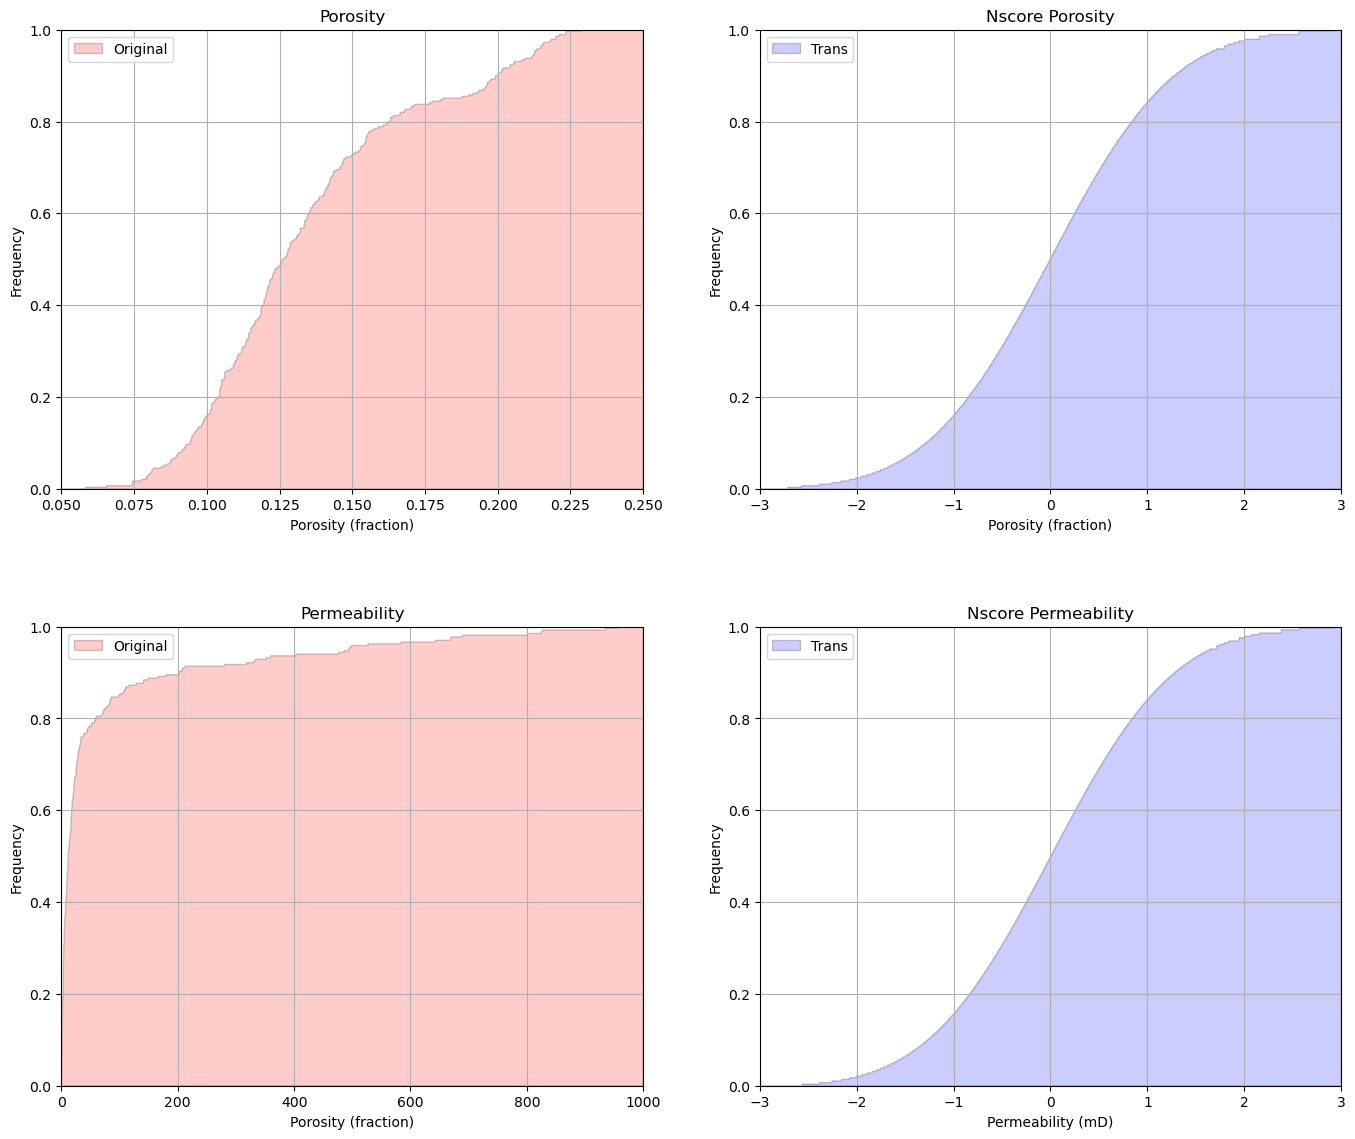

In [12]:
plt.subplot(221)                                        # plot original sand and shale porosity histograms
plt.hist(df['Porosity'], facecolor='red',bins=np.linspace(0.0,0.25,1000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.05,0.25]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(222)  
plt.hist(df['NPor'], facecolor='blue',bins=np.linspace(-3.0,3.0,1000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label = 'Trans')
plt.xlim([-3.0,3.0]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Nscore Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(223)                                        # plot nscore transformed sand and shale histograms
plt.hist(df['Perm'], facecolor='red',bins=np.linspace(0.0,1000.0,100000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.0,1000.0]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(224)                                        # plot nscore transformed sand and shale histograms
plt.hist(df['NPerm'], facecolor='blue',bins=np.linspace(-3.0,3.0,100000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label = 'Trans')
plt.xlim([-3.0,3.0]); plt.ylim([0,1.0])
plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Nscore Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
plt.show()

The normal score transform has correctly transformed the porosity and permeability to standard normal.

#### Inspection of Posted Data

Data visualization is very useful to detect patterns. Our brains are very good at pattern detection. I promote quantitative methods and recognize issues with cognitive bias, but it is important to recognize the value is expert intepretation based on data visualization.

* This data visualization will also be important to assist with parameter selection for the quantitative methods later.

Let's plot the location maps of normal score transforms of porosity and permeability for all facies. We will also include a cross plot of the nscore permeability vs. porosity colored by facies to aid with comparison in spatial features between the porosity and permeability data.

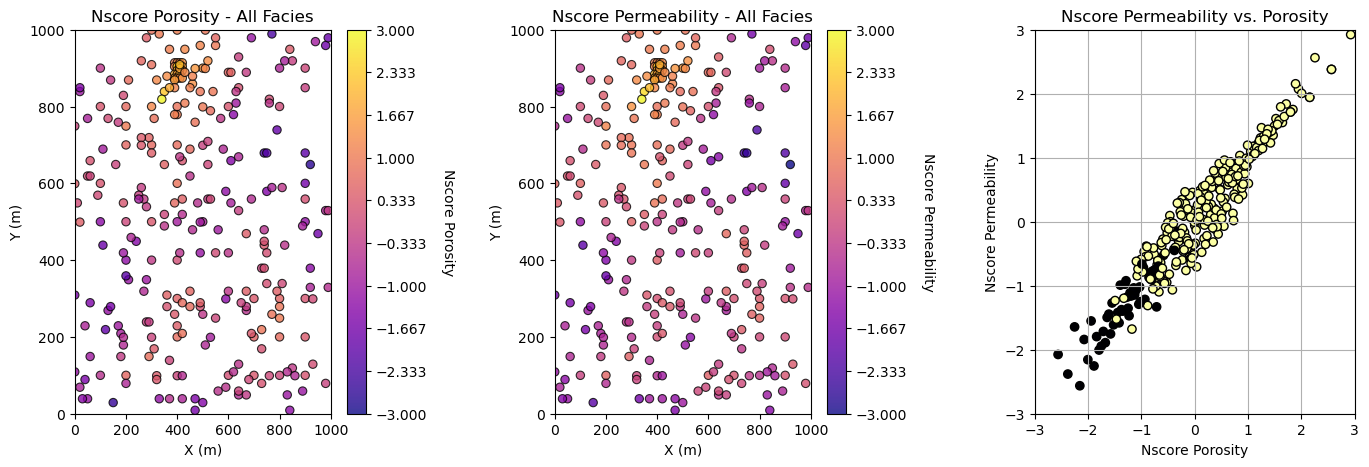

In [13]:
cmap = plt.cm.plasma                                    # set the color map
plt.subplot(131)                                        # location map of normal score transform of porosity
GSLIB.locmap_st(df,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(132)                                        # location map of normal score transform of permeability
GSLIB.locmap_st(df,'X','Y','NPerm',0,1000,0,1000,-3,3,'Nscore Permeability - All Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplot(133)
facies = df['Facies'].values +0.01                      # normal score porosity / permeability scatter plot color coded by facies
plt.scatter(df['NPor'],df['NPerm'],c = facies,edgecolor = 'black',cmap = plt.cm.inferno)
#plt.plot([-3,3],[-3,3],color = 'black')
plt.xlabel(r'Nscore Porosity')
plt.ylabel(r'Nscore Permeability')
plt.title('Nscore Permeability vs. Porosity')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.5, hspace=0.3)
plt.show()

What do you see?  Here's my observations:

* there is a high degree of spatial agreement between porosity and permeability, this is supported by the high correlation evident in the cross plot.
* there are no discontinuities that could suggest that facies represent a distinct change, rather the porosity and permeability seem continuous and the assigned facies are a truncation of their continous behavoir, we doing 'ok' with no facies
* suspect a 045 azimuth major direction of continuity (up - right)
* there may be cycles in the 135 azimuth 
* there will not likely be a nugget effect, but there is an hint of some short scale discontinuity?

**Do you agree?** If you have a different observations, drop me a line at mpyrcz@austin.utexas.edu and I'll add to this lesson with credit.


#### Experimental Variograms

We can use the location maps to help determine good variogram calculation parameters. For example:

```p
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 50.0; nlag = 7; bandh = 9999.9; azi = azi; atol = 22.5; isill = 1
```
* **tmin**, **tmax** are trimming limits - set to have no impact, no need to filter the data
* **lag_dist**, **lag_tol** are the lag distance, lag tolerance - set based on the common data spacing (100m) and tolerance as 100% of lag distance for additonal smoothing
* **nlag** is number of lags - set to extend just past 50 of the data extent
* **bandh** is the horizontal band width - set to have no effect
* **azi** is the azimuth -  it has not effect since we set atol, the azimuth tolerance, to 90.0
* **isill** is a boolean to standardize the distribution to a variance of 1 - it has no effect since the previous nscore transform sets the variance to 1.0

#### Dashboard for Interactive Variogram Calculation

Below we make a dashboard with the ipywidgets and matplotlib Python packages for calculating experimental variograms.

In [14]:
# interactive calculation of the experimental variogram
l = widgets.Text(value='                              Variogram Calculation Interactive Demonstration, Michael Pyrcz, Associate Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))
lag = widgets.FloatSlider(min = 20, max = 500, value = 100, step = 10, description = 'lag',orientation='vertical',layout=Layout(width='90px', height='200px'))
lag.style.handle_color = 'gray'

lag_tol = widgets.FloatSlider(min = 20, max = 500, value = 50, step = 10, description = 'lag tolerance',orientation='vertical',layout=Layout(width='90px', height='200px'))
lag_tol.style.handle_color = 'gray'

nlag = widgets.IntSlider(min = 1, max = 100, value = 10, step = 1, description = 'number of lags',orientation='vertical',layout=Layout(width='90px', height='200px'))
nlag.style.handle_color = 'gray'

azi = widgets.FloatSlider(min = 0, max = 360, value = 0, step = 5, description = 'azimuth',orientation='vertical',layout=Layout(width='90px', height='200px'))
azi.style.handle_color = 'gray'

azi_tol = widgets.FloatSlider(min = 10, max = 90, value = 20, step = 5, description = 'azimuth tolerance',orientation='vertical',layout=Layout(width='120px', height='200px'))
azi_tol.style.handle_color = 'gray'

bandwidth = widgets.FloatSlider(min = 100, max = 2000, value = 2000, step = 100, description = 'bandwidth',orientation='vertical',layout=Layout(width='90px', height='200px'))
azi_tol.style.handle_color = 'gray'


ui1 = widgets.HBox([lag,lag_tol,nlag,azi,azi_tol,bandwidth],) # basic widget formatting    
ui = widgets.VBox([l,ui1],)

def f_make(lag,lag_tol,nlag,azi,azi_tol,bandwidth):     # function to take parameters, calculate variogram and plot
#    text_trap = io.StringIO()
#    sys.stdout = text_trap
    tmin = -9999.9; tmax = 9999.9
    lags, gammas, npps = geostats.gamv(df,"X","Y","NPor",tmin,tmax,lag,lag_tol,nlag,azi,azi_tol,bandwidth,isill=1.0)
    
    plt.subplot(111)                                    # plot experimental variogram
    plt.scatter(lags,gammas,color = 'black',s = npps*0.1,label = 'Azimuth ' +str(azi))
    plt.plot([0,2000],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Porosity Variogram - Azi ' + str(azi))
    plt.xlim([0,1000]); plt.ylim([0,1.8])
    plt.grid(True)
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.3, hspace=0.3)
    plt.show()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(f_make, {'lag':lag,'lag_tol':lag_tol,'nlag':nlag,'azi':azi,'azi_tol':azi_tol,'bandwidth':bandwidth})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating

### Interactive Variogram Calculation Demostration

* calculate omnidirectional and direction experimental variograms 

### The Problem

Calculate interpretable experimental variograms for sparse, irregularly-space spatial data.

* **azimuth** is the azimuth of the lag vector

* **azimuth tolerance** is the maximum allowable departure from the azimuth

* **unit lag distance** the size of the bins in lag distance

* **lag distance tolerance** - the allowable tolerance in lage distance

* **number of lags** - number of lags in the experimental variogram

* **bandwidth** - maximum departure from the lag vector

In [15]:
display(ui, interactive_plot)                           # display the interactive plot

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 1 Axes>', 'i…

<i>&copy; Copyright daytum 2025. All Rights Reserved</i>